[I 2024-10-19 11:53:33,076] A new study created in memory with name: no-name-6cb3d5e4-cdbc-489a-8c78-63186c317741
/var/folders/2z/b1lzf17n4z90pz80khfc42fw0000gp/T/ipykernel_91744/2851020458.py:70: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
[I 2024-10-19 11:53:35,113] Trial 0 finished with value: 34.69750213623047 and parameters: {'num_layers': 2, 'num_neurons_layer_0': 96, 'num_neurons_layer_1': 104, 'learning_rate': 0.0031791255651031584, 'activation': 'tanh'}. Best is trial 0 with value: 34.69750213623047.
/var/folders/2z/b1lzf17n4z90pz80khfc42fw0000gp/T/ipykernel_91744/2851020458.py:70: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use su

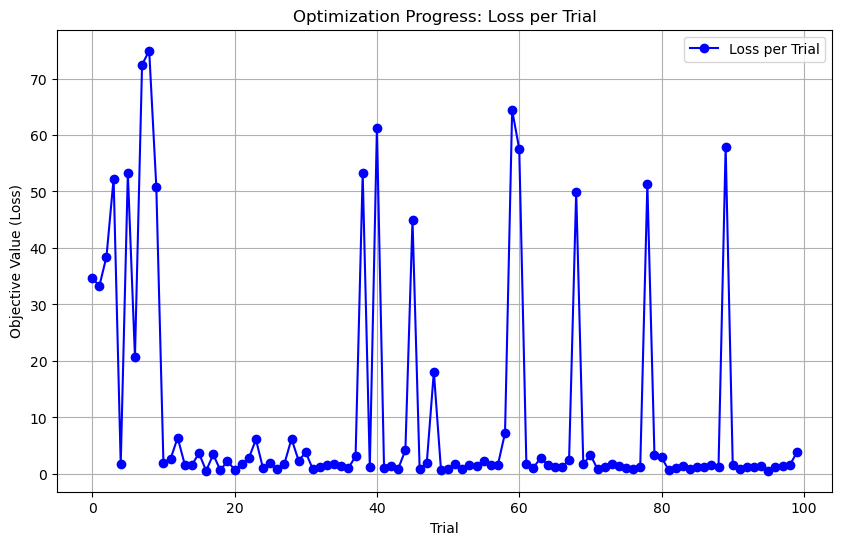

Best hyperparameters:  {'num_layers': 4, 'num_neurons_layer_0': 96, 'num_neurons_layer_1': 44, 'num_neurons_layer_2': 76, 'num_neurons_layer_3': 108, 'learning_rate': 0.0018988387858488664, 'activation': 'relu'}
Best trial loss:  0.5573984831571579
Epoch 1/50
1/1 [==============================] - 0s 106ms/step - loss: 84.7947
Epoch 2/50
1/1 [==============================] - 0s 1ms/step - loss: 81.3528
Epoch 3/50
1/1 [==============================] - 0s 1ms/step - loss: 77.6796
Epoch 4/50
1/1 [==============================] - 0s 1ms/step - loss: 73.8313
Epoch 5/50
1/1 [==============================] - 0s 1ms/step - loss: 69.6430
Epoch 6/50
1/1 [==============================] - 0s 1ms/step - loss: 64.9818
Epoch 7/50
1/1 [==============================] - 0s 1ms/step - loss: 59.5986
Epoch 8/50
1/1 [==============================] - 0s 1ms/step - loss: 53.3724
Epoch 9/50
1/1 [==============================] - 0s 1ms/step - loss: 46.1687
Epoch 10/50
1/1 [==============================

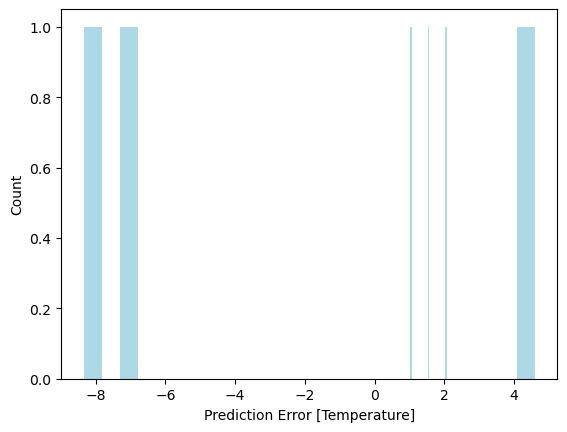

In [36]:
### import optuna
import tensorflow as tf
import optuna
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Assume data_entrance and data_exit have already been loaded and preprocessed as before

# Load data
data_entrance = pd.read_csv('/Users/hsiaopingni/Desktop/Hsiao-Ping PhD/Data/MAU_paper/AI_model_MAU_Entrance.csv', encoding='unicode_escape')
#data_entrance = pd.read_csv(r'C:\Users\Hsiao-ping.ni\ASU Dropbox\Hsiao-Ping Ni\PhD\Data\3rd paper- MAU\AI_model_MAU_Entrance.csv', encoding='unicode_escape')
data_exit = pd.read_csv(r'/Users/hsiaopingni/Desktop/Hsiao-Ping PhD/Data/MAU_paper/AI_model_MAU_Exit.csv', encoding='unicode_escape')
#data_exit = pd.read_csv(r'C:\Users\Hsiao-ping.ni\ASU Dropbox\Hsiao-Ping Ni\PhD\Data\3rd paper- MAU\AI_model_MAU_Exit.csv', encoding='unicode_escape')


# Define features and labels for entrance and exit datasets

data_entrance = data_entrance.drop(['Count','Which MAU'], axis=1)
train_dataset_entrance = data_entrance.sample(frac=0.8, random_state=0)
test_dataset_entrance = data_entrance.drop(train_dataset_entrance.index)

data_exit = data_exit.drop(['Count','Which MAU'], axis=1)
train_dataset_exit = data_exit.sample(frac=0.8, random_state=0)
test_dataset_exit = data_exit.drop(train_dataset_exit.index)

train_features_entrance = train_dataset_entrance.copy()
test_features_entrance = test_dataset_entrance.copy()
train_labels_entrance = train_features_entrance.pop('Temperature (°F)')
test_labels_entrance = test_features_entrance.pop('Temperature (°F)')

train_features_exit = train_dataset_exit.copy()
test_features_exit = test_dataset_exit.copy()
train_labels_exit = train_features_exit.pop('Temperature (°F)')
test_labels_exit = test_features_exit.pop('Temperature (°F)')

trial_losses = []

# Function to create a model with the given hyperparameters
# Function to create a model with a specific number of neurons in each layer
def create_model(input_shape, neurons_per_layer, activation, learning_rate):
    model = tf.keras.Sequential()
    
    # Add the first layer with input shape
    model.add(layers.Dense(neurons_per_layer[0], activation=activation, input_shape=(input_shape,)))
    
    # Add subsequent layers with specified number of neurons
    for neurons in neurons_per_layer[1:]:
        model.add(layers.Dense(neurons, activation=activation))
    
    model.add(layers.Dense(1))  # Output layer
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
                  loss='mean_absolute_error')
    return model

# Objective function to optimize both entrance and exit models
def objective(trial):
    # Suggest number of layers
    num_layers = trial.suggest_int('num_layers', 1, 5)
    
    # Suggest a different number of neurons for each layer
    neurons_per_layer = []
    for i in range(num_layers):
        neurons = trial.suggest_int(f'num_neurons_layer_{i}', 16, 128, step=4)  # Each layer can have 16 to 128 neurons
        neurons_per_layer.append(neurons)
    
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
    activation = trial.suggest_categorical('activation', ['relu', 'tanh'])

    # Create models for both entrance and exit
    model_entrance = create_model(train_features_entrance.shape[1], neurons_per_layer, activation, learning_rate)
    model_exit = create_model(train_features_exit.shape[1], neurons_per_layer, activation, learning_rate)

    # Split data into training and validation for both entrance and exit
    x_train_entrance, x_val_entrance, y_train_entrance, y_val_entrance = train_test_split(train_features_entrance, train_labels_entrance, test_size=0.2, random_state=42)
    x_train_exit, x_val_exit, y_train_exit, y_val_exit = train_test_split(train_features_exit, train_labels_exit, test_size=0.2, random_state=42)

    # Train both models
    model_entrance.fit(x_train_entrance, y_train_entrance, validation_data=(x_val_entrance, y_val_entrance), 
                       epochs=100, batch_size=32, verbose=0)
    model_exit.fit(x_train_exit, y_train_exit, validation_data=(x_val_exit, y_val_exit), 
                   epochs=100, batch_size=32, verbose=0)

    # Evaluate both models on validation data
    val_loss_entrance = model_entrance.evaluate(x_val_entrance, y_val_entrance, verbose=0)
    val_loss_exit = model_exit.evaluate(x_val_exit, y_val_exit, verbose=0)

    # Combine the two objectives by returning a weighted sum
    combined_loss = 0.5 * val_loss_entrance + 0.5 * val_loss_exit
    trial_losses.append(combined_loss)  # Append the loss to the list
    
    return combined_loss

# Create a study and optimize both models simultaneously
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(trial_losses, label='Loss per Trial', marker='o', color='blue')
plt.title('Optimization Progress: Loss per Trial')
plt.xlabel('Trial')
plt.ylabel('Objective Value (Loss)')
plt.legend()
plt.grid(True)
plt.show()

# Print best hyperparameters
print("Best hyperparameters: ", study.best_params)
print("Best trial loss: ", study.best_value)

# Build the final optimized models
def build_best_model(best_params, input_shape):
    num_layers = best_params['num_layers']
    
    # Reconstruct neurons per layer using the best parameters
    neurons_per_layer = [best_params[f'num_neurons_layer_{i}'] for i in range(num_layers)]
    activation = best_params['activation']
    learning_rate = best_params['learning_rate']

    model = create_model(input_shape, neurons_per_layer, activation, learning_rate)
    return model

# Create the final models using the best hyperparameters
final_model_entrance = build_best_model(study.best_params, train_features_entrance.shape[1])
final_model_exit = build_best_model(study.best_params, train_features_exit.shape[1])

# Train the final models on the full datasets
final_model_entrance.fit(train_features_entrance, train_labels_entrance, epochs=50, batch_size=32, verbose=1)
final_model_exit.fit(train_features_exit, train_labels_exit, epochs=50, batch_size=32, verbose=1)

# Optionally, evaluate on a test set (if you have one)
test_loss_entrance = final_model_entrance.evaluate(test_features_entrance, test_labels_entrance, verbose=1)
print(f"Test set loss for entrance: {test_loss_entrance}")
test_loss_exit = final_model_exit.evaluate(test_features_exit, test_labels_exit, verbose=1)
print(f"Test set loss for exit: {test_loss_exit}")



test_features_entrance = np.asarray(test_features_entrance).astype(np.float32)
print("Test features Entrance:", test_features_entrance)
print()

test_results_entrance = {}
test_results_entrance['dnn_model'] = final_model_entrance.evaluate(test_features_entrance, test_labels_entrance, verbose=0)
print("Test result Entrance:", test_results_entrance)
print()

test_features_exit = np.asarray(test_features_exit).astype(np.float32)
print("Test features Exit:", test_features_exit)
print()

test_results_exit = {}
test_results_exit['dnn_model'] = final_model_exit.evaluate(test_features_exit, test_labels_exit, verbose=0)
print("Test result Exit:", test_results_exit)
print()

pd.DataFrame(test_results_entrance, index=['Mean absolute error [Temperature]']).T

pd.DataFrame(test_results_exit, index=['Mean absolute error [Temperature]']).T

test_predictions_entrance = final_model_entrance.predict(test_features_entrance).flatten()
print("Test Predictions Entrance:", test_predictions_entrance)
print()

test_predictions_exit = final_model_exit.predict(test_features_exit).flatten()
print("Test Predictions Exit:", test_predictions_exit)
print()

error_entrance = test_predictions_entrance - test_labels_entrance
print("Error entrance:", error_entrance)
print()

error_exit = test_predictions_entrance - test_labels_entrance
print("Error entrance:", error_exit)
print()

plt.hist(error_entrance, bins=25, color='lightblue')
plt.xlabel('Prediction Error [Temperature]')
_ = plt.ylabel('Count')

error_exit = test_predictions_exit - test_labels_exit
error_exit

plt.hist(error_exit, bins=25, color='lightblue')
plt.xlabel('Prediction Error [Temperature]')
_ = plt.ylabel('Count')

# average error
average_error_entrance = np.mean(error_entrance)
print("Average error for entrance:", average_error_entrance)
print()

average_error_exit = np.mean(error_exit)
print("Average error for exit:", average_error_exit)
print()

# mean squared error
from sklearn.metrics import mean_squared_error
mse_entrance = mean_squared_error(test_labels_entrance, test_predictions_entrance)
mse_exit = mean_squared_error(test_labels_exit, test_predictions_exit)
print("Mean Squared Error for entrance:", mse_entrance)
print("Mean Squared Error for exit:", mse_exit)
print()

# mean absolute error
from sklearn.metrics import mean_absolute_error
mae_entrance = mean_absolute_error(test_labels_entrance, test_predictions_entrance)
mae_exit = mean_absolute_error(test_labels_exit, test_predictions_exit)
print("Mean Absolute Error for entrance:", mae_entrance)
print("Mean Absolute Error for exit:", mae_exit)
print()

import numpy as np

def mean_absolute_percentage_error(y_actual, y_pred):
    y_actual, y_pred = np.array(y_actual), np.array(y_pred)
    return np.mean(np.abs((y_actual - y_pred) / y_actual)) * 100

mape = mean_absolute_percentage_error(test_labels_entrance, test_predictions_entrance)
print(f'MAPE for entrance: {mape:.2f}%')
print()

mape = mean_absolute_percentage_error(test_labels_exit, test_predictions_exit)
print(f'MAPE for exit: {mape:.2f}%')





In [37]:
print("Trial Losses (Objective Values) as a Column:")
for i, loss in enumerate(trial_losses):
    print(f"{i + 1}|{loss}")

Trial Losses (Objective Values) as a Column:
1|34.69750213623047
2|33.26291847229004
3|38.4738883972168
4|52.27557945251465
5|1.6691640615463257
6|53.2325439453125
7|20.672980308532715
8|72.46095657348633
9|74.92560577392578
10|50.808589935302734
11|1.9961306750774384
12|2.6473604142665863
13|6.397132873535156
14|1.6512845754623413
15|1.5846658945083618
16|3.6480650156736374
17|0.5573984831571579
18|3.432360351085663
19|0.6437810361385345
20|2.2798715829849243
21|0.7307395935058594
22|1.759839415550232
23|2.7868435978889465
24|6.086453914642334
25|0.9517516940832138
26|1.9237339943647385
27|0.9013595283031464
28|1.805418610572815
29|6.199496120214462
30|2.3360455855727196
31|3.8138644099235535
32|0.805599182844162
33|1.1520233452320099
34|1.520596832036972
35|1.8090832829475403
36|1.3883832693099976
37|1.0315780937671661
38|3.1331940293312073
39|53.20252227783203
40|1.1441790163516998
41|61.24877738952637
42|1.0925585627555847
43|1.4163119047880173
44|0.9446678161621094
45|4.1961619257

[I 2024-10-17 15:25:07,391] A new study created in memory with name: no-name-932699d1-1750-43e4-8f45-bcfc497f791e
[I 2024-10-17 15:25:07,392] A new study created in memory with name: no-name-691068ae-3990-4de2-b86d-3a6fd7eb3162


[I 2024-10-17 15:25:07,968] Trial 0 finished with value: 71.9831314086914 and parameters: {'num_layers': 1, 'neurons_per_layer': 98, 'activation_function': 'tanh'}. Best is trial 0 with value: 71.9831314086914.
[I 2024-10-17 15:25:08,550] Trial 1 finished with value: 6.385701656341553 and parameters: {'num_layers': 3, 'neurons_per_layer': 39, 'activation_function': 'relu'}. Best is trial 1 with value: 6.385701656341553.
[I 2024-10-17 15:25:09,129] Trial 2 finished with value: 16.70258331298828 and parameters: {'num_layers': 3, 'neurons_per_layer': 110, 'activation_function': 'relu'}. Best is trial 1 with value: 6.385701656341553.
[I 2024-10-17 15:25:09,676] Trial 3 finished with value: 29.608551025390625 and parameters: {'num_layers': 1, 'neurons_per_layer': 93, 'activation_function': 'relu'}. Best is trial 1 with value: 6.385701656341553.
[I 2024-10-17 15:25:10,224] Trial 4 finished with value: 60.0728874206543 and parameters: {'num_layers': 1, 'neurons_per_layer': 54, 'activation_fun

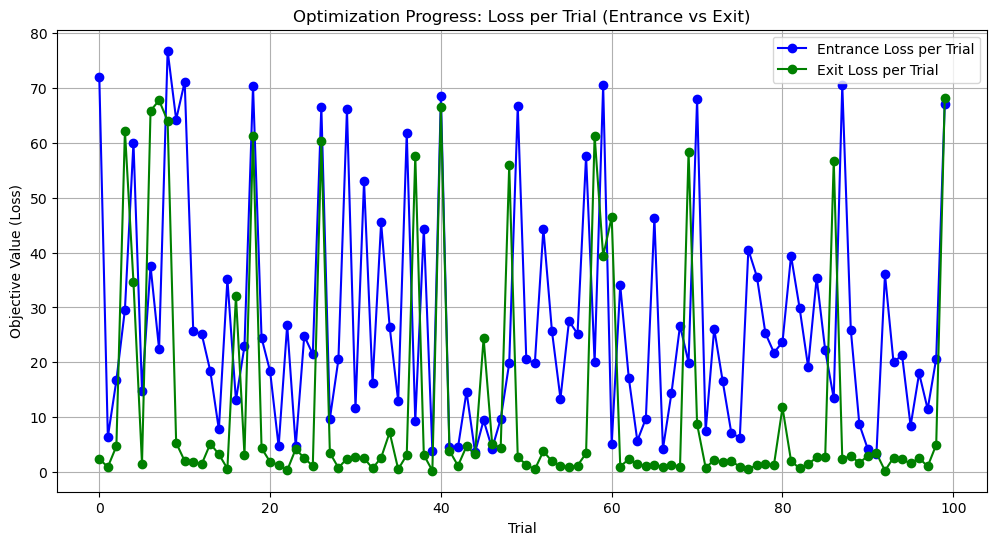

[I 2024-10-16 16:01:17,381] Trial 55 finished with value: 0.8125137090682983 and parameters: {'num_layers': 3, 'neurons_per_layer': 102, 'activation_function': 'relu'}. Best is trial 54 with value: 0.7426666021347046.
[I 2024-10-16 16:01:18,790] Trial 56 finished with value: 3.382586717605591 and parameters: {'num_layers': 3, 'neurons_per_layer': 89, 'activation_function': 'relu'}. Best is trial 54 with value: 0.7426666021347046.
[I 2024-10-16 16:01:20,208] Trial 57 finished with value: 2.3462371826171875 and parameters: {'num_layers': 3, 'neurons_per_layer': 97, 'activation_function': 'relu'}. Best is trial 54 with value: 0.7426666021347046.
[I 2024-10-16 16:01:21,789] Trial 58 finished with value: 2.6053574085235596 and parameters: {'num_layers': 3, 'neurons_per_layer': 99, 'activation_function': 'relu'}. Best is trial 54 with value: 0.7426666021347046.
[I 2024-10-16 16:01:23,281] Trial 59 finished with value: 1.7927825450897217 and parameters: {'num_layers': 3, 'neurons_per_layer': 

[I 2024-10-16 16:02:11,572] Trial 93 finished with value: 1.6530898809432983 and parameters: {'num_layers': 3, 'neurons_per_layer': 109, 'activation_function': 'relu'}. Best is trial 54 with value: 0.7426666021347046.
[I 2024-10-16 16:02:12,964] Trial 94 finished with value: 2.5466339588165283 and parameters: {'num_layers': 3, 'neurons_per_layer': 46, 'activation_function': 'relu'}. Best is trial 54 with value: 0.7426666021347046.
[I 2024-10-16 16:02:14,250] Trial 95 finished with value: 0.7526947259902954 and parameters: {'num_layers': 2, 'neurons_per_layer': 126, 'activation_function': 'relu'}. Best is trial 54 with value: 0.7426666021347046.
[I 2024-10-16 16:02:15,561] Trial 96 finished with value: 2.0273146629333496 and parameters: {'num_layers': 2, 'neurons_per_layer': 122, 'activation_function': 'relu'}. Best is trial 54 with value: 0.7426666021347046.
[I 2024-10-16 16:02:16,873] Trial 97 finished with value: 0.9605743288993835 and parameters: {'num_layers': 2, 'neurons_per_layer

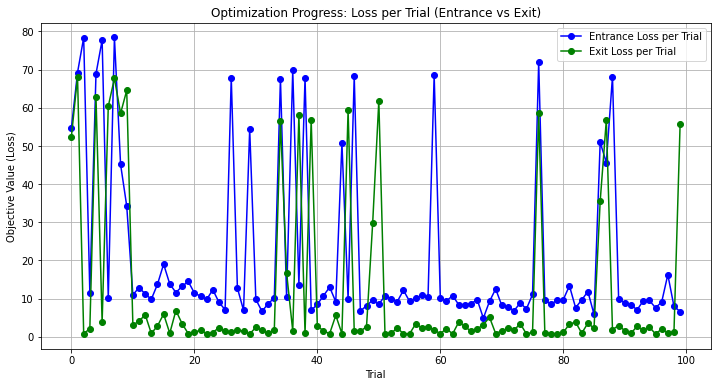

In [3]:
import optuna
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

# Lists to store the losses for each trial
trial_losses_entrance = []
trial_losses_exit = []

# Define the model building function
def build_model(num_layers, neurons_per_layer, activation_function):
    model = keras.Sequential()
    model.add(layers.Dense(neurons_per_layer, activation=activation_function, input_shape=(train_features_entrance.shape[1],)))
    
    for _ in range(num_layers - 1):
        model.add(layers.Dense(neurons_per_layer, activation=activation_function))
        
    model.add(layers.Dense(1))  # Output layer for regression
    
    model.compile(optimizer='adam', loss='mean_absolute_error')
    return model

# Define the objective function for MAU entrance
def objective_entrance(trial):
    # Suggest hyperparameters
    num_layers = trial.suggest_int('num_layers', 1, 3)
    neurons_per_layer = trial.suggest_int('neurons_per_layer', 32, 128)
    activation_function = trial.suggest_categorical('activation_function', ['relu', 'tanh'])

    # Build the model for entrance
    model = build_model(num_layers, neurons_per_layer, activation_function)

    # Train the model for entrance
    history = model.fit(train_features_entrance, train_labels_entrance, epochs=50, batch_size=32, 
                        validation_split=0.2, verbose=0)
    
    # Get the validation loss for entrance
    val_loss_entrance = history.history['val_loss'][-1]  # Last epoch's validation loss
    
    # Append the entrance loss to the list
    trial_losses_entrance.append(val_loss_entrance)
    
    return val_loss_entrance

# Define the objective function for MAU exit
def objective_exit(trial):
    # Suggest hyperparameters
    num_layers = trial.suggest_int('num_layers', 1, 3)
    neurons_per_layer = trial.suggest_int('neurons_per_layer', 32, 128)
    activation_function = trial.suggest_categorical('activation_function', ['relu', 'tanh'])

    # Build the model for exit
    model = build_model(num_layers, neurons_per_layer, activation_function)

    # Train the model for exit
    history = model.fit(train_features_exit, train_labels_exit, epochs=50, batch_size=32, 
                        validation_split=0.2, verbose=0)
    
    # Get the validation loss for exit
    val_loss_exit = history.history['val_loss'][-1]  # Last epoch's validation loss
    
    # Append the exit loss to the list
    trial_losses_exit.append(val_loss_exit)
    
    return val_loss_exit

# Create two separate Optuna studies for entrance and exit
study_entrance = optuna.create_study(direction='minimize')
study_exit = optuna.create_study(direction='minimize')

# Run optimization for entrance and exit models
study_entrance.optimize(objective_entrance, n_trials=100)
study_exit.optimize(objective_exit, n_trials=100)

# After optimization, plot the losses for entrance and exit
plt.figure(figsize=(12, 6))

# Plot entrance losses
plt.plot(trial_losses_entrance, label='Entrance Loss per Trial', marker='o', color='blue')

# Plot exit losses
plt.plot(trial_losses_exit, label='Exit Loss per Trial', marker='o', color='green')

plt.title('Optimization Progress: Loss per Trial (Entrance vs Exit)')
plt.xlabel('Trial')
plt.ylabel('Objective Value (Loss)')
plt.legend()
plt.grid(True)
plt.show()
